# Plot the runtimes of DrugGym

In [97]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore') 

import rdkit
import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes_ = torch.tensor(table.to_numpy())

In [2]:
import os

def get_tcp_objectives():

    dockstring_dir = f'{path}/dockstring_targets/'
    files = os.listdir(dockstring_dir)
    configs = sorted([f for f in files if 'conf' in f])
    targets = sorted([f for f in files if 'target' in f])

    idx = 0
    with open(dockstring_dir + configs[idx], 'r') as f:
        config_ = f.readlines()
        config_ = [c.replace('\n', '') for c in config_]
        config_ = [c.split(' = ') for c in config_ if c]
        config_ = {c[0]: float(c[1]) for c in config_}

    target = targets[idx]
    name = target.split('_')[0]

    config_.update({
        'size_x': 22.5,
        'size_y': 22.5,
        'size_z': 22.5,
    })

    from dgym.envs.oracle import \
        ConstantOracle, RandomOracle, DockingOracle, CatBoostOracle, RDKitOracle, NoisyOracle
    from dgym.envs.utility import ClassicUtilityFunction

    config = {
        'search_mode': 'detailed',
        'scoring': 'vina',
        'seed': 5,
        **config_
    }

    pIC50_oracle = DockingOracle(
        f'{name} pIC50',
        receptor_path=f'{path}/dockstring_targets/{name}_target.pdbqt',
        config=config
    )
    constant_oracle = ConstantOracle('Constant', constant=1)
    random_oracle = RandomOracle('Random')
    log_P_oracle = RDKitOracle('Log P', descriptor='MolLogP')
    log_S_oracle = CatBoostOracle(
        'Log S', path='../dgym/envs/models/aqsolcb.model')
    
    return pIC50_oracle, log_P_oracle, log_S_oracle, constant_oracle, random_oracle

In [5]:
from dgym.envs.utility import ClassicUtilityFunction, Policy

# Get objectives
pIC50_oracle, log_P_oracle, log_S_oracle, constant_oracle, random_oracle = get_tcp_objectives()

# Define utility functions
pIC50_utility = ClassicUtilityFunction(
    pIC50_oracle, ideal=(9.5, 13), acceptable=(8, 13))
log_P_utility = ClassicUtilityFunction(
    log_P_oracle, ideal=(0.5, 1.85), acceptable=(-0.5, 3.5))
log_S_utility = ClassicUtilityFunction(
    log_S_oracle, ideal=(-3, 1), acceptable=(-4, 1))
constant_utility = ClassicUtilityFunction(
    constant_oracle, ideal=(3, 4), acceptable=(2, 5))
random_utility = ClassicUtilityFunction(
    random_oracle, ideal=(3, 4), acceptable=(2, 5))

# Assemble assays and surrogate models
assays = [
    pIC50_oracle,
    log_P_oracle,
    log_S_oracle,
    pIC50_oracle.surrogate(sigma=1.0),
    log_P_oracle.surrogate(sigma=1.0),
    log_S_oracle.surrogate(sigma=1.0),
]

# Environment tolerates acceptable ADMET
from copy import deepcopy
utility_agent = Policy(
    utility_functions = [pIC50_utility, log_P_utility, log_S_utility],
    weights = [0.8, 0.1, 0.1]
)
utility_env = deepcopy(utility_agent)
utility_env.utility_functions[1].ideal = utility_env.utility_functions[1].acceptable
utility_env.utility_functions[2].ideal = utility_env.utility_functions[2].acceptable

In [98]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes_),
    reactions,
    cache = True
)

In [29]:
import time
from tqdm.auto import tqdm
import io
from contextlib import redirect_stdout
f = io.StringIO()

with redirect_stdout(f):
        
    sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

    design_runtimes = []
    score_runtimes = []
    for trial in range(1, 25):
        for size in tqdm(sizes):
            
            # Ideate random molecules
            t = time.time()
            molecules = designer.design(size)
            time_elapsed = t - time.time()
            design_runtimes.append({
                'size': size,
                'time': time_elapsed,
                'trial': trial
            })

            # Score molecules
            t = time.time()
            utility_agent(molecules)
            time_elapsed = t - time.time()
            score_runtimes.append({
                'size': size,
                'time': time_elapsed,
                'trial': trial
            })

  0%|          | 0/10 [00:00<?, ?it/s]

[15:09:42] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[15:09:45] Can't kekulize mol.  Unkekulized atoms: 10 12 13
[15:09:45] Can't kekulize mol.  Unkekulized atoms: 12 14 18
[15:09:51] Can't kekulize mol.  Unkekulized atoms: 15 16 18
[15:09:51] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 19
[15:10:00] Can't kekulize mol.  Unkekulized atoms: 16 19 20 23 24 25 26
[15:10:12] Can't kekulize mol.  Unkekulized atoms: 11 13 15
[15:10:12] Can't kekulize mol.  Unkekulized atoms: 9 11 13
[15:10:12] Can't kekulize mol.  Unkekulized atoms: 20 22 24
[15:10:12] Can't kekulize mol.  Unkekulized atoms: 13 15 18
[15:10:12] Can't kekulize mol.  Unkekulized atoms: 10 12 13
[15:10:12] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[15:10:12] Can't kekulize mol.  Unkekulized atoms: 11 13 15
[15:10:12] Can't kekulize mol.  Unkekulized atoms: 11 13 15
[15:10:36] Can't kekulize mol.  Unkekulized atoms: 19 20 21
[15:10:36] Can't kekulize mol.  Unkekulized atoms: 9 11 12
[15:10:36] C

  0%|          | 0/10 [00:00<?, ?it/s]

[15:11:10] Can't kekulize mol.  Unkekulized atoms: 16 18 21
[15:11:12] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[15:11:16] Can't kekulize mol.  Unkekulized atoms: 14 15 17
[15:11:16] Can't kekulize mol.  Unkekulized atoms: 14 16 17
[15:11:22] Can't kekulize mol.  Unkekulized atoms: 11 13 15
[15:11:32] Can't kekulize mol.  Unkekulized atoms: 14 16 18
[15:11:32] Can't kekulize mol.  Unkekulized atoms: 12 14 15
[15:11:32] Can't kekulize mol.  Unkekulized atoms: 13 15 17
[15:11:32] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 20
[15:11:46] Can't kekulize mol.  Unkekulized atoms: 17 19 20
[15:11:46] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18
[15:11:46] Can't kekulize mol.  Unkekulized atoms: 18 21 23 24 27 28 32
[15:11:46] Can't kekulize mol.  Unkekulized atoms: 9 11 14
[15:11:46] Can't kekulize mol.  Unkekulized atoms: 17 18 19
[15:11:46] Can't kekulize mol.  Unkekulized atoms: 13 15 17
[15:11:46] Can't kekulize mol.  Unkekulized atoms: 13 15 17
[15:11:46] 

  0%|          | 0/10 [00:00<?, ?it/s]

[15:15:33] Can't kekulize mol.  Unkekulized atoms: 16 18 19 20 21 22 24
[15:15:44] Can't kekulize mol.  Unkekulized atoms: 9 11 13
[15:15:52] Can't kekulize mol.  Unkekulized atoms: 16 18 21
[15:15:52] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17
[15:15:52] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[15:15:52] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[15:15:53] Can't kekulize mol.  Unkekulized atoms: 12
[15:16:06] Can't kekulize mol.  Unkekulized atoms: 11 13 14
[15:16:06] Can't kekulize mol.  Unkekulized atoms: 15 16 19
[15:16:06] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[15:16:06] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[15:16:32] Can't kekulize mol.  Unkekulized atoms: 7 9 11 12 14 15 16
[15:16:32] Can't kekulize mol.  Unkekulized atoms: 9 10 12
[15:16:32] Can't kekulize mol.  Unkekulized atoms: 13 15 17
[15:16:32] Can't kekulize mol.  Unkekulized atoms: 14 15 17
[15:16:35] Can't kekulize mol.  Unkekulized atoms: 12 14 1

  0%|          | 0/10 [00:00<?, ?it/s]

[15:19:18] Can't kekulize mol.  Unkekulized atoms: 10 12 13
[15:19:21] Can't kekulize mol.  Unkekulized atoms: 12 15 16
[15:19:27] Can't kekulize mol.  Unkekulized atoms: 9 11 13
[15:19:27] Can't kekulize mol.  Unkekulized atoms: 12 14 16
[15:19:27] Can't kekulize mol.  Unkekulized atoms: 15 17 18
[15:19:35] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[15:19:49] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 15 16 17
[15:19:49] Can't kekulize mol.  Unkekulized atoms: 7 9 10 11 12 13 14
[15:19:49] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[15:19:49] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[15:19:49] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25 26 30
[15:19:49] Can't kekulize mol.  Unkekulized atoms: 12 15 17
[15:19:49] Can't kekulize mol.  Unkekulized atoms: 11 13 15
[15:20:10] Can't kekulize mol.  Unkekulized atoms: 12 15 17
[15:20:10] Can't kekulize mol.  Unkekulized atoms: 12 14 16
[15:20:10] Can't kekulize mol.  Unkekulized atoms

  0%|          | 0/10 [00:00<?, ?it/s]

[15:22:47] Can't kekulize mol.  Unkekulized atoms: 12 13 15
[15:22:56] Can't kekulize mol.  Unkekulized atoms: 15 16 17
[15:22:56] Can't kekulize mol.  Unkekulized atoms: 22 24 26
[15:22:59] Can't kekulize mol.  Unkekulized atoms: 8 10 11
[15:22:59] Can't kekulize mol.  Unkekulized atoms: 9 10 12
[15:22:59] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[15:22:59] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[15:22:59] Can't kekulize mol.  Unkekulized atoms: 17 19 21
[15:22:59] Can't kekulize mol.  Unkekulized atoms: 9 10 11
[15:23:27] Can't kekulize mol.  Unkekulized atoms: 15 17 18
[15:23:27] Can't kekulize mol.  Unkekulized atoms: 15 17 20 21 24 25 30
[15:23:27] Can't kekulize mol.  Unkekulized atoms: 14 15 18
[15:23:27] Can't kekulize mol.  Unkekulized atoms: 16 19 21
[15:23:27] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 16
[15:23:27] Can't kekulize mol.  Unkekulized atoms: 14 16 17
[15:23:27] Can't kekulize mol.  Unkekulized atoms: 10 12 14
[15:23:27] Ca

  0%|          | 0/10 [00:00<?, ?it/s]

[15:24:03] Can't kekulize mol.  Unkekulized atoms: 26 27 28 29 30
[15:24:21] Can't kekulize mol.  Unkekulized atoms: 13 15 18
[15:24:21] Can't kekulize mol.  Unkekulized atoms: 14 15 16
[15:24:23] Can't kekulize mol.  Unkekulized atoms: 10 12 13
[15:24:23] Can't kekulize mol.  Unkekulized atoms: 11 13 15
[15:24:23] Can't kekulize mol.  Unkekulized atoms: 20 22 25
[15:24:23] Can't kekulize mol.  Unkekulized atoms: 10 11 12
[15:24:23] Can't kekulize mol.  Unkekulized atoms: 17 20 21
[15:24:40] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[15:24:40] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[15:24:40] Can't kekulize mol.  Unkekulized atoms: 12 14 15
[15:24:40] Can't kekulize mol.  Unkekulized atoms: 11 12 14
[15:24:40] Can't kekulize mol.  Unkekulized atoms: 17 20 21 23 24 25 26
[15:25:02] Can't kekulize mol.  Unkekulized atoms: 27 29 32 33 37 38 42
[15:25:02] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[15:25:03] Can't kekulize mol.  Unkekulized atoms: 1

  0%|          | 0/10 [00:00<?, ?it/s]

[15:27:35] Can't kekulize mol.  Unkekulized atoms: 14 16 17 18 19 20 21
[15:27:35] Can't kekulize mol.  Unkekulized atoms: 13 14 16
[15:27:35] Can't kekulize mol.  Unkekulized atoms: 13 15 17
[15:27:58] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
[15:27:58] Can't kekulize mol.  Unkekulized atoms: 9 10 12
[15:27:58] Can't kekulize mol.  Unkekulized atoms: 17 20 22
[15:27:58] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19
[15:27:58] Can't kekulize mol.  Unkekulized atoms: 11 13 15
[15:28:11] Can't kekulize mol.  Unkekulized atoms: 15 16 17
[15:28:11] Can't kekulize mol.  Unkekulized atoms: 10 12 14
[15:28:11] Can't kekulize mol.  Unkekulized atoms: 11 13 15 17 18 20 21
[15:28:11] Can't kekulize mol.  Unkekulized atoms: 8 10 12
[15:28:11] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[15:28:11] Can't kekulize mol.  Unkekulized atoms: 17 19 20
[15:28:11] Can't kekulize mol.  Unkekulized atoms: 18 19 22
[15:28:11] Can't kekulize mol.  Unkekulize

  0%|          | 0/10 [00:00<?, ?it/s]

[15:30:52] Can't kekulize mol.  Unkekulized atoms: 17 19 21
[15:30:59] Can't kekulize mol.  Unkekulized atoms: 8 9 12
[15:30:59] Can't kekulize mol.  Unkekulized atoms: 8 9 12
[15:31:20] Can't kekulize mol.  Unkekulized atoms: 15 17 19
[15:31:20] Can't kekulize mol.  Unkekulized atoms: 10 12 14
[15:31:20] Can't kekulize mol.  Unkekulized atoms: 16 17 18
[15:31:20] Can't kekulize mol.  Unkekulized atoms: 16 17 18
[15:31:37] Can't kekulize mol.  Unkekulized atoms: 21 23 24
[15:31:37] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[15:31:37] Can't kekulize mol.  Unkekulized atoms: 14 15 17
[15:31:37] Can't kekulize mol.  Unkekulized atoms: 14 15 17
[15:31:37] Can't kekulize mol.  Unkekulized atoms: 18 20 22
[15:31:37] Can't kekulize mol.  Unkekulized atoms: 14 16 17
[15:31:37] Can't kekulize mol.  Unkekulized atoms: 12 14 16
[15:31:37] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18
[15:32:14] Can't kekulize mol.  Unkekulized atoms: 12 14 15
[15:32:14] Can't kekulize mol.  

  0%|          | 0/10 [00:00<?, ?it/s]

[15:33:47] Can't kekulize mol.  Unkekulized atoms: 11 12 14
[15:33:47] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[15:34:02] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29
[15:34:02] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[15:34:02] Can't kekulize mol.  Unkekulized atoms: 16 17 20
[15:34:15] Can't kekulize mol.  Unkekulized atoms: 11 12 14
[15:34:15] Can't kekulize mol.  Unkekulized atoms: 11 13 14
[15:34:15] Can't kekulize mol.  Unkekulized atoms: 21 23 26
[15:34:15] Can't kekulize mol.  Unkekulized atoms: 13 15 16
[15:34:15] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[15:34:34] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15
[15:34:34] Can't kekulize mol.  Unkekulized atoms: 15 17 18
[15:34:34] Can't kekulize mol.  Unkekulized atoms: 14 17 19
[15:34:34] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[15:34:34] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[15:35:16] Can't kekulize mol.  Unkekulized atoms: 1

  0%|          | 0/10 [00:00<?, ?it/s]

[15:35:58] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[15:36:13] Can't kekulize mol.  Unkekulized atoms: 11 14 16
[15:36:13] Can't kekulize mol.  Unkekulized atoms: 14 15 17
[15:36:13] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32
[15:36:28] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[15:36:28] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17
[15:36:28] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[15:36:28] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 22 23
[15:36:28] Can't kekulize mol.  Unkekulized atoms: 14 15 17 18 19 20 21
[15:36:28] Can't kekulize mol.  Unkekulized atoms: 12 13 15
[15:36:28] Can't kekulize mol.  Unkekulized atoms: 10 13 15
[15:36:28] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 21
[15:36:28] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[15:36:28] Can't kekulize mol.  Unkekulized atoms: 13 14 17
[15:36:28] Can't kekulize mol.  Unkekulized atoms: 13 14 17
[15:36:52] Can't kekulize mol.

  0%|          | 0/10 [00:00<?, ?it/s]

[15:38:10] Can't kekulize mol.  Unkekulized atoms: 15 16 18
[15:38:21] Can't kekulize mol.  Unkekulized atoms: 13
[15:38:21] Can't kekulize mol.  Unkekulized atoms: 12 14 16
[15:38:21] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
[15:38:29] Can't kekulize mol.  Unkekulized atoms: 14 16 18
[15:38:29] Can't kekulize mol.  Unkekulized atoms: 16 17 18
[15:38:43] Can't kekulize mol.  Unkekulized atoms: 13 15 16
[15:38:43] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
[15:38:43] Can't kekulize mol.  Unkekulized atoms: 26 28 30
[15:38:43] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[15:38:43] Can't kekulize mol.  Unkekulized atoms: 18 21 22
[15:38:43] Can't kekulize mol.  Unkekulized atoms: 16 17 20
[15:38:43] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[15:38:43] Can't kekulize mol.  Unkekulized atoms: 9 11 12
[15:38:43] Can't kekulize mol.  Unkekulized atoms: 9 11 12
[15:39:12] Can't kekulize mol.  Unkekulized atoms: 17 19 20


  0%|          | 0/10 [00:00<?, ?it/s]

[15:40:37] Can't kekulize mol.  Unkekulized atoms: 14 16 19 20 22 23 27
[15:40:54] Can't kekulize mol.  Unkekulized atoms: 19 22 24
[15:40:54] Can't kekulize mol.  Unkekulized atoms: 11 13 14
[15:41:14] Can't kekulize mol.  Unkekulized atoms: 10 12 13
[15:41:14] Can't kekulize mol.  Unkekulized atoms: 16 18 19
[15:41:34] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[15:41:34] Can't kekulize mol.  Unkekulized atoms: 17 20 22 23 27
[15:41:34] Can't kekulize mol.  Unkekulized atoms: 15 16 18
[15:41:34] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[15:41:34] Can't kekulize mol.  Unkekulized atoms: 15 16 17
[15:41:34] Can't kekulize mol.  Unkekulized atoms: 9 11 12
[15:41:34] Can't kekulize mol.  Unkekulized atoms: 9 11 12
[15:41:34] Can't kekulize mol.  Unkekulized atoms: 9 11 12
[15:41:34] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 18 19
[15:41:34] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[15:41:34] Can't kekulize mol.  Unkekulized ato

  0%|          | 0/10 [00:00<?, ?it/s]

[15:43:19] Can't kekulize mol.  Unkekulized atoms: 9 11 12
[15:43:24] Can't kekulize mol.  Unkekulized atoms: 14 15 16
[15:43:24] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 19
[15:43:29] Can't kekulize mol.  Unkekulized atoms: 14 17 19 20 23 24 28
[15:43:29] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[15:43:29] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18
[15:43:29] Can't kekulize mol.  Unkekulized atoms: 8 10 13 14 18 19 20
[15:43:39] Can't kekulize mol.  Unkekulized atoms: 13 14 15
[15:43:39] Can't kekulize mol.  Unkekulized atoms: 12 14 16
[15:43:39] Can't kekulize mol.  Unkekulized atoms: 11 13 16
[15:43:53] Can't kekulize mol.  Unkekulized atoms: 12 13 14
[15:43:53] Can't kekulize mol.  Unkekulized atoms: 16 19 21 22 25 26 30
[15:43:53] Can't kekulize mol.  Unkekulized atoms: 14 15 16
[15:43:53] Can't kekulize mol.  Unkekulized atoms: 18 20 23
[15:44:15] Can't kekulize mol.  Unkekulized atoms: 12 14 16
[15:44:15] Can't kekulize mol.  Unkekulized atom

  0%|          | 0/10 [00:00<?, ?it/s]

[15:47:57] Can't kekulize mol.  Unkekulized atoms: 13 15 17
[15:48:05] Can't kekulize mol.  Unkekulized atoms: 17 19 20
[15:48:05] Can't kekulize mol.  Unkekulized atoms: 18 19 21
[15:48:05] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[15:48:05] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 19
[15:48:05] Can't kekulize mol.  Unkekulized atoms: 14 16 18
[15:48:05] Can't kekulize mol.  Unkekulized atoms: 17 19 22
[15:48:13] Can't kekulize mol.  Unkekulized atoms: 12 13 14
[15:48:13] Can't kekulize mol.  Unkekulized atoms: 15 17 18
[15:48:13] Can't kekulize mol.  Unkekulized atoms: 10 12 13 16 17 18 19
[15:48:31] Can't kekulize mol.  Unkekulized atoms: 19 20 21 23 24 25 27
[15:48:31] Can't kekulize mol.  Unkekulized atoms: 15 17 19 23 24 25 26 27 28
[15:49:01] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[15:49:01] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[15:49:01] Can't kekulize mol.  Unkekulized atoms: 12 15 17
[15:49:01] Can't kekulize mol.  Un

  0%|          | 0/10 [00:00<?, ?it/s]

[15:50:15] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[15:50:21] Can't kekulize mol.  Unkekulized atoms: 13 15 16
[15:50:27] Can't kekulize mol.  Unkekulized atoms: 11 13 16 17 19 20 24
[15:50:39] Can't kekulize mol.  Unkekulized atoms: 11 13 15
[15:50:39] Can't kekulize mol.  Unkekulized atoms: 15 17 18
[15:50:52] Can't kekulize mol.  Unkekulized atoms: 13 15 16
[15:50:52] Can't kekulize mol.  Unkekulized atoms: 21 22 25
[15:51:09] Can't kekulize mol.  Unkekulized atoms: 13 15 16
[15:51:09] Can't kekulize mol.  Unkekulized atoms: 13 15 16
[15:51:09] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[15:51:09] Can't kekulize mol.  Unkekulized atoms: 19 21 23
[15:51:09] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
[15:51:09] Can't kekulize mol.  Unkekulized atoms: 13 14 17
[15:51:09] Can't kekulize mol.  Unkekulized atoms: 14 17 19
[15:51:09] Can't kekulize mol.  Unkekulized atoms: 23 25 26 29 30 31 32
[15:51:09] Can't kekulize mol.  Unkekulized at

  0%|          | 0/10 [00:00<?, ?it/s]

[15:52:28] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[15:52:32] Can't kekulize mol.  Unkekulized atoms: 11 13 14
[15:52:37] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 18 19
[15:52:37] Can't kekulize mol.  Unkekulized atoms: 15 17 18 20 21 23 24
[15:52:48] Can't kekulize mol.  Unkekulized atoms: 16 17 20
[15:52:48] Can't kekulize mol.  Unkekulized atoms: 18 19 21
[15:53:02] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[15:53:02] Can't kekulize mol.  Unkekulized atoms: 19 21 24
[15:53:02] Can't kekulize mol.  Unkekulized atoms: 15 17 18
[15:53:03] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[15:53:03] Can't kekulize mol.  Unkekulized atoms: 14 16 18
[15:53:03] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[15:53:03] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[15:53:03] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 19
[15:53:03] Can't kekulize mol.  Unkekulized atoms: 14 15 17
[15:53:03] Can't kekulize mol.  Unkekuli

  0%|          | 0/10 [00:00<?, ?it/s]

[15:53:42] Can't kekulize mol.  Unkekulized atoms: 12 15 17
[15:54:03] Can't kekulize mol.  Unkekulized atoms: 18 19 21
[15:54:03] Can't kekulize mol.  Unkekulized atoms: 11
[15:54:03] Can't kekulize mol.  Unkekulized atoms: 14 15 17
[15:54:03] Can't kekulize mol.  Unkekulized atoms: 10 12 13
[15:54:03] Can't kekulize mol.  Unkekulized atoms: 12 14 17
[15:54:03] Can't kekulize mol.  Unkekulized atoms: 13 15 18
[15:54:03] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 26 27
[15:54:03] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17
[15:54:14] Can't kekulize mol.  Unkekulized atoms: 9 12 14 15 19
[15:54:14] Can't kekulize mol.  Unkekulized atoms: 11 14 15 16 17 18 20
[15:54:14] Can't kekulize mol.  Unkekulized atoms: 12 15 16
[15:54:14] Can't kekulize mol.  Unkekulized atoms: 8 10 11
[15:54:14] Can't kekulize mol.  Unkekulized atoms: 13 15 17
[15:54:14] Can't kekulize mol.  Unkekulized atoms: 10 11 13
[15:54:14] Can't kekulize mol.  Unkekulized atoms: 31 34 35 38 39 40 41


  0%|          | 0/10 [00:00<?, ?it/s]

[15:57:17] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[15:57:17] Can't kekulize mol.  Unkekulized atoms: 11 13 15 16 17 18 20
[15:57:21] Can't kekulize mol.  Unkekulized atoms: 13 15 17
[15:57:29] Can't kekulize mol.  Unkekulized atoms: 16 18 21
[15:57:29] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[15:57:29] Can't kekulize mol.  Unkekulized atoms: 14 16 18
[15:57:29] Can't kekulize mol.  Unkekulized atoms: 14 15 17
[15:57:29] Can't kekulize mol.  Unkekulized atoms: 10 12 13
[15:57:32] Can't kekulize mol.  Unkekulized atoms: 17 18 19
[15:57:32] Can't kekulize mol.  Unkekulized atoms: 20 22 23 24 25 26 27
[15:57:52] Can't kekulize mol.  Unkekulized atoms: 20 23 24
[15:57:52] Can't kekulize mol.  Unkekulized atoms: 10 11 13
[15:57:52] Can't kekulize mol.  Unkekulized atoms: 12 14 16
[15:57:52] Can't kekulize mol.  Unkekulized atoms: 14 17 19
[15:57:52] Can't kekulize mol.  Unkekulized atoms: 18 20 21
[15:58:19] Can't kekulize mol.  Unkekulized atoms: 1

  0%|          | 0/10 [00:00<?, ?it/s]

[16:00:37] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:00:37] Can't kekulize mol.  Unkekulized atoms: 14 16 17
[16:00:48] Can't kekulize mol.  Unkekulized atoms: 10 12 14
[16:00:48] Can't kekulize mol.  Unkekulized atoms: 10 12 13
[16:00:48] Can't kekulize mol.  Unkekulized atoms: 10 11 12
[16:00:48] Can't kekulize mol.  Unkekulized atoms: 19 21 24
[16:00:48] Can't kekulize mol.  Unkekulized atoms: 14 18 19
[16:01:10] Can't kekulize mol.  Unkekulized atoms: 16 17 18
[16:01:10] Can't kekulize mol.  Unkekulized atoms: 12 14 16
[16:01:10] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[16:01:10] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:01:10] Can't kekulize mol.  Unkekulized atoms: 18 20 21
[16:01:10] Can't kekulize mol.  Unkekulized atoms: 11 13 15
[16:01:10] Can't kekulize mol.  Unkekulized atoms: 17 19 20
[16:01:10] Can't kekulize mol.  Unkekulized atoms: 14 16 18
[16:01:10] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 20
[16:01:10] Can't

  0%|          | 0/10 [00:00<?, ?it/s]

[16:02:34] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
[16:03:06] Can't kekulize mol.  Unkekulized atoms: 8 9 12
[16:03:06] Can't kekulize mol.  Unkekulized atoms: 11 13 14 15 16 17 18
[16:03:06] Can't kekulize mol.  Unkekulized atoms: 16 18 19
[16:03:06] Can't kekulize mol.  Unkekulized atoms: 11 13 15
[16:03:06] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18
[16:03:06] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18
[16:03:06] Can't kekulize mol.  Unkekulized atoms: 12 14 15 17 18 19 20
[16:03:08] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:03:08] Can't kekulize mol.  Unkekulized atoms: 19 21 24
[16:03:08] Can't kekulize mol.  Unkekulized atoms: 10 11 14
[16:03:08] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
[16:03:08] Can't kekulize mol.  Unkekulized atoms: 12 14 15
[16:03:08] Can't kekulize mol.  Unkekulized atoms: 13 14 15
[16:03:08] Can't kekulize mol.  Unkekulized atoms: 11 13 14
[16:03:08] Can't kekulize mol.  Unkekulized atoms: 

  0%|          | 0/10 [00:00<?, ?it/s]

[16:04:56] Can't kekulize mol.  Unkekulized atoms: 17 19 20
[16:04:56] Can't kekulize mol.  Unkekulized atoms: 17 19 20
[16:05:01] Can't kekulize mol.  Unkekulized atoms: 13 14 16
[16:05:01] Can't kekulize mol.  Unkekulized atoms: 14 15 16
[16:05:07] Can't kekulize mol.  Unkekulized atoms: 10 12 15
[16:05:07] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:05:07] Can't kekulize mol.  Unkekulized atoms: 24 25 27
[16:05:16] Can't kekulize mol.  Unkekulized atoms: 18 20 21
[16:05:16] Can't kekulize mol.  Unkekulized atoms: 21 23 24 26 27 30 32
[16:05:16] Can't kekulize mol.  Unkekulized atoms: 7 9 12
[16:05:16] Can't kekulize mol.  Unkekulized atoms: 7 9 12
[16:05:29] Can't kekulize mol.  Unkekulized atoms: 14 15 18 19 22 23 27
[16:05:29] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 22
[16:05:29] Can't kekulize mol.  Unkekulized atoms: 12 14 17
[16:05:29] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:05:29] Can't kekulize mol.  Unkekulized atoms: 13 16 17
[1

  0%|          | 0/10 [00:00<?, ?it/s]

[16:07:13] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:07:13] Can't kekulize mol.  Unkekulized atoms: 11 13 15
[16:07:20] Can't kekulize mol.  Unkekulized atoms: 11 12 14
[16:07:31] Can't kekulize mol.  Unkekulized atoms: 20 23 25
[16:07:31] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18
[16:07:31] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 16
[16:07:31] Can't kekulize mol.  Unkekulized atoms: 18 20 22
[16:07:46] Can't kekulize mol.  Unkekulized atoms: 17 19 20
[16:07:46] Can't kekulize mol.  Unkekulized atoms: 14 16 17
[16:07:46] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 16
[16:07:46] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[16:07:46] Can't kekulize mol.  Unkekulized atoms: 13 15 17
[16:07:46] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:07:46] Can't kekulize mol.  Unkekulized atoms: 14 16 18
[16:07:46] Can't kekulize mol.  Unkekulized atoms: 14 16 18
[16:07:46] Can't kekulize mol.  Unkekulized atoms: 14 15 17

  0%|          | 0/10 [00:00<?, ?it/s]

[16:08:38] Can't kekulize mol.  Unkekulized atoms: 15 18 19 22 23 25 26
[16:08:49] Can't kekulize mol.  Unkekulized atoms: 9 11 14
[16:08:49] Can't kekulize mol.  Unkekulized atoms: 14 17 18
[16:09:04] Can't kekulize mol.  Unkekulized atoms: 15 17 19
[16:09:04] Can't kekulize mol.  Unkekulized atoms: 7 11 13
[16:09:04] Can't kekulize mol.  Unkekulized atoms: 27 29 30
[16:09:04] Can't kekulize mol.  Unkekulized atoms: 13 15 17
[16:09:04] Can't kekulize mol.  Unkekulized atoms: 27 29 31
[16:09:04] Can't kekulize mol.  Unkekulized atoms: 9 11 12
[16:09:04] Can't kekulize mol.  Unkekulized atoms: 18 20 21
[16:09:04] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
[16:09:04] Can't kekulize mol.  Unkekulized atoms: 17 18 20
[16:09:26] Can't kekulize mol.  Unkekulized atoms: 17 19 20
[16:09:26] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[16:09:27] Can't kekulize mol.  Unkekulized atoms: 8 9 11
[16:09:27] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 18
[16:09:27] Can'

  0%|          | 0/10 [00:00<?, ?it/s]

[16:12:07] Can't kekulize mol.  Unkekulized atoms: 13 15 17
[16:12:16] Can't kekulize mol.  Unkekulized atoms: 8 9 12
[16:12:25] Can't kekulize mol.  Unkekulized atoms: 10 13 14
[16:12:37] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:12:37] Can't kekulize mol.  Unkekulized atoms: 15 16 18 19 21 22 26
[16:12:37] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[16:12:56] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 20 21
[16:12:56] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
[16:12:56] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 20
[16:12:56] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15
[16:12:56] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15
[16:13:35] Can't kekulize mol.  Unkekulized atoms: 12 14 17
[16:13:35] Can't kekulize mol.  Unkekulized atoms: 13 15 18
[16:13:35] Can't kekulize mol.  Unkekulized atoms: 17 19 21
[16:13:35] Can't kekulize mol.  Unkekulized atoms: 11 13 15
[16:13:35] Can't kekulize mol.  Unkekuli

Write to disk.

In [38]:
import pandas as pd

df_design = pd.DataFrame(design_runtimes)
df_design['parameter'] = 'design'

df_score = pd.DataFrame(score_runtimes)
df_score['parameter'] = 'score'

df = pd.concat([df_design, df_score])
df.to_csv('../../dgym-data/runtimes.csv')

Analyze.

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 0, 'Number of Molecules')

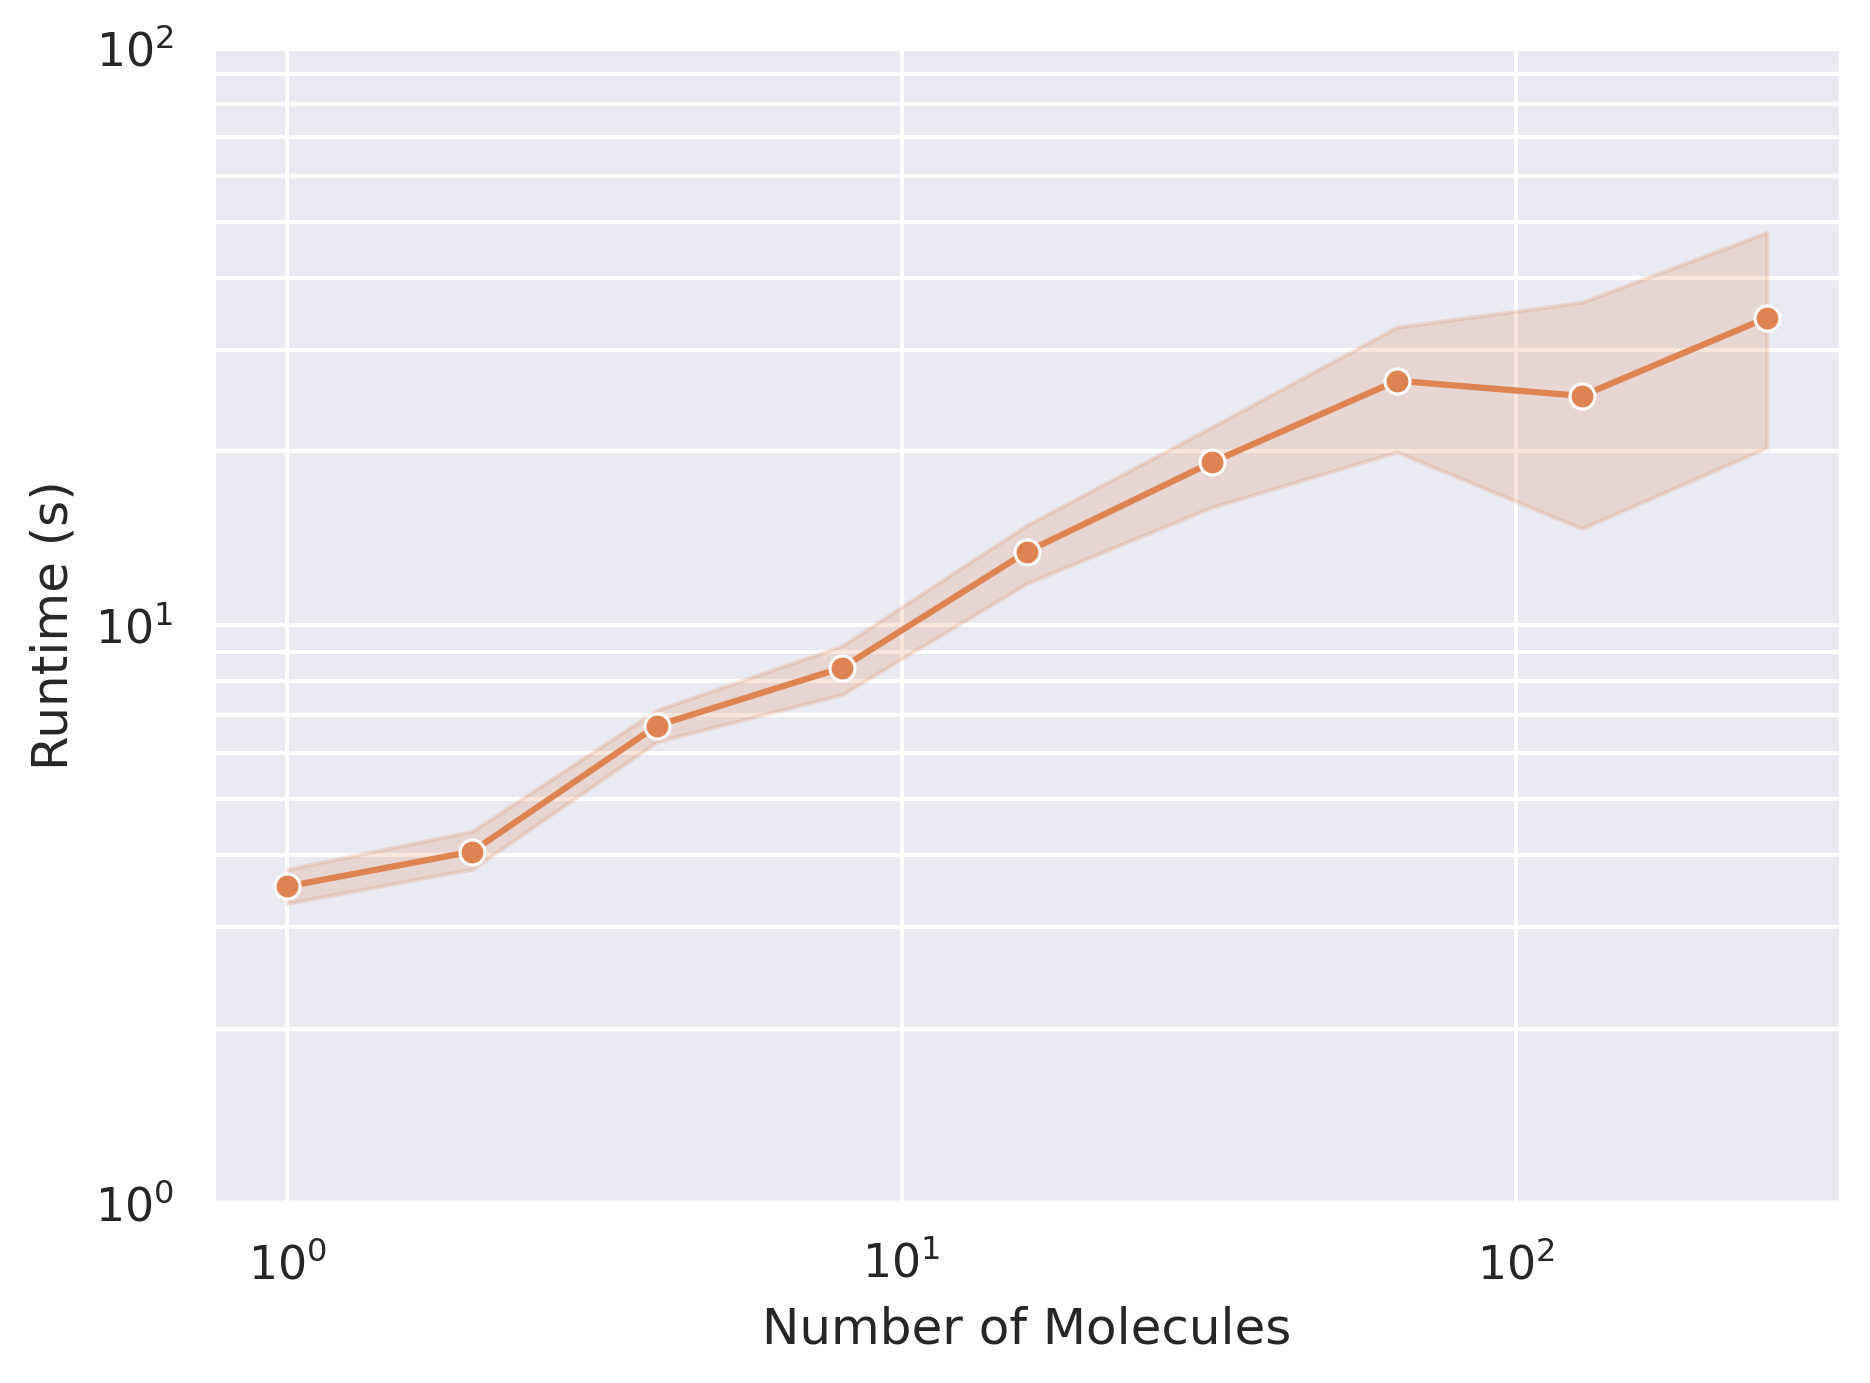

In [86]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

df['Runtime (s)'] = -df['time']

plt.figure(figsize=(7, 5), dpi=300)
sns.set()
g = sns.lineplot(
    df.query('size <= 256').query('parameter == "score"'),
    x='size',
    y='Runtime (s)',
    marker='o',
    color=sns.color_palette()[1]
)

# iterate through each axes
g.grid(True, which="both", axis='y')
locmin = ticker.LogLocator(
    base=10,
    subs=np.arange(0.1, 1, 0.1),
    numticks=10
)
g.yaxis.set_minor_locator(locmin)

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e0, 1e2)
plt.xlabel('Number of Molecules')

## Finding analogs of *one molecule*

In [105]:
import time
from tqdm.auto import tqdm
import io

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

from contextlib import redirect_stdout
f = io.StringIO()

with redirect_stdout(f):
        
    sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256]

    analog_runtimes = []
    for trial in tqdm(range(1, 1_000)):
        starting_point = designer.design(1)[0]
        for size in sizes:
            
            # Make designer
            designer = Designer(
                Generator(building_blocks, fingerprints, sizes_),
                reactions,
                cache = True
            )

            # Ideate analogs
            t = time.time()
            molecules = designer.design(starting_point, size=size)
            time_elapsed = t - time.time()
            analog_runtimes.append({
                'size': size,
                'time': time_elapsed,
                'trial': trial
            })

df_analogs = pd.DataFrame(analog_runtimes)
df_analogs['Runtime (s)'] = -df_analogs['time']
df_analogs.to_csv('../../dgym-data/analogs_runtime.csv')

  0%|          | 0/999 [00:00<?, ?it/s]

Text(0.5, 0, 'Number of Molecules')

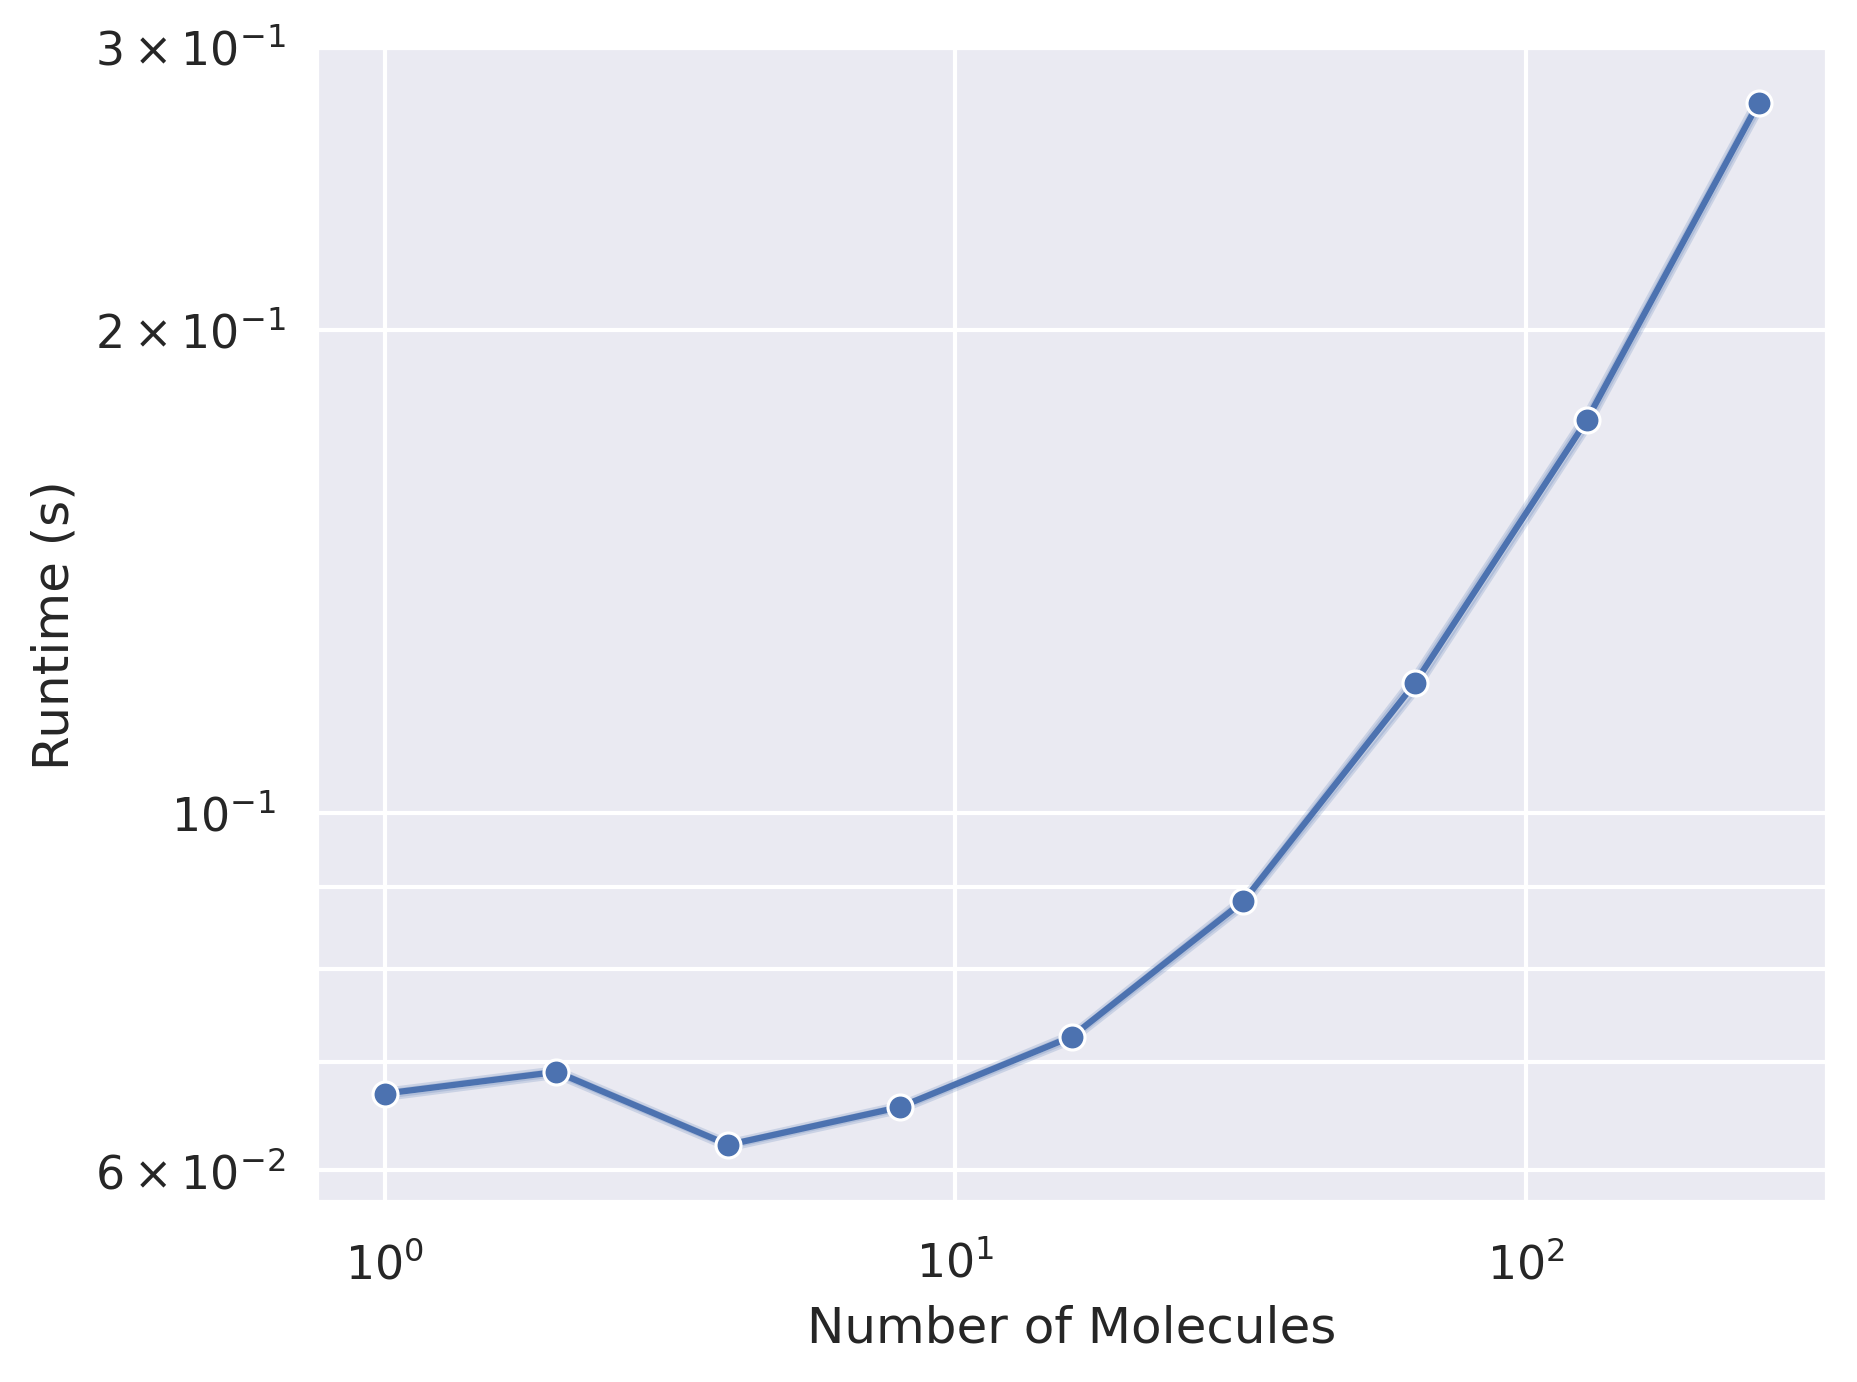

In [124]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(6.5, 5), dpi=300)
sns.set()
g = sns.lineplot(
    df_analogs.query('size <= 256'),
    x='size',
    y='Runtime (s)',
    marker='o',
    # color=sns.color_palette()[1]
)

# iterate through each axes
g.grid(True, which="both", axis='y')
locmin = ticker.LogLocator(
    base=10,
    subs=np.arange(0.1, 1, 0.1),
    numticks=10
)
g.yaxis.set_minor_locator(locmin)

plt.xscale('log')
plt.yscale('log')
plt.ylim(None, 3e-1)
plt.xlabel('Number of Molecules')